In [1]:
import torch
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
use_cuda = torch.cuda.is_available()

Mon Nov 10 09:17:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090      WDDM  |   00000000:01:00.0  On |                  N/A |
| 34%   39C    P8             29W /  350W |   23701MiB /  24576MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
SEED = 42
WEIGHTED = True

In [3]:
from datasets import *
import pandas as pd
import numpy as np
train = pd.DataFrame(load_dataset("dev_phase2/subtask3/train/spa", split="train"))
train.head()

C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


id  \
0  spa_bc7bf0a1b710cd724cf96b5eeb020bff   
1  spa_688aec0f6abf4e0be44ecbfa886251cc   
2  spa_47019efabe7295c630bcc04bd0429230   
3  spa_8b4b244dbb90e0a813661ed12a1af5af   
4  spa_e2f37881da08b8d7b6eb07bc37356746   

                                                text  stereotype  \
0  "bueno, tirando"\ny si hay repregunta, entonce...           0   
1                "caimos en su retorica de indigena"           0   
2   "cara de indigena sudaca", porque pio asi luego?           0   
3  "violar a una nina es menos grave que un abort...           0   
4              "yo decido quien es judio y quien no"           1   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             1               0                 1                0   
4             0               1                 0                0   

   invalidation  
0             0  
1             0  
2             0  
3             0  
4             0

In [4]:
labels = ["stereotype", "vilification", "dehumanization", "extreme_language", "lack_of_empathy", "invalidation"]
def get_text_and_label(df):
  return df.rename(columns={"text": "text"})[["text"] + labels]
train = get_text_and_label(train)
val = get_text_and_label(train)
test = get_text_and_label(train)
print(f"Dataset size: <{len(train.index)}:{len(val.index)}:{len(test.index)}>")
train.head(10)

Dataset size: <3305:3305:3305>


text  stereotype  \
0  "bueno, tirando"\ny si hay repregunta, entonce...           0   
1                "caimos en su retorica de indigena"           0   
2   "cara de indigena sudaca", porque pio asi luego?           0   
3  "violar a una nina es menos grave que un abort...           0   
4              "yo decido quien es judio y quien no"           1   
5  #8m e cada dia en defensa dun xornalismo femin...           0   
6  #chvnoticias la muerte de ninos no se transa p...           0   
7  #corrupcion#prensa#desestabilizadora#nido#rata...           1   
8  #ecuador | la cancilleria implementa plan de a...           0   
9  #importante | te decimos la ubicacion de los 1...           0   

   vilification  dehumanization  extreme_language  lack_of_empathy  \
0             0               0                 0                0   
1             0               0                 0                0   
2             0               0                 0                0   
3             1               0                 1                0   
4             0               1                 0                0   
5             0               0                 0                0   
6             0               1                 0                1   
7             1               0                 0                0   
8             0               0                 0                0   
9             0               0                 0                0   

   invalidation  
0             0  
1             0  
2             0  
3             0  
4             0  
5             0  
6             0  
7             1  
8             0  
9             0

In [5]:
def generate_multilabel_df(df):
  df["labels"] = np.empty((len(df), len(labels))).tolist()
  for index, row in df.iterrows():
    row_labels = [row[label] for label in labels]
    for i in range(len(labels)):
      df.loc[index, "labels"][i] = row_labels[i]
  return df[["text", "labels"]]
train = generate_multilabel_df(train)
val = generate_multilabel_df(val)
test = generate_multilabel_df(test)
train.head(10)

text              labels
0  "bueno, tirando"\ny si hay repregunta, entonce...  [0, 0, 0, 0, 0, 0]
1                "caimos en su retorica de indigena"  [0, 0, 0, 0, 0, 0]
2   "cara de indigena sudaca", porque pio asi luego?  [0, 0, 0, 0, 0, 0]
3  "violar a una nina es menos grave que un abort...  [0, 1, 0, 1, 0, 0]
4              "yo decido quien es judio y quien no"  [1, 0, 1, 0, 0, 0]
5  #8m e cada dia en defensa dun xornalismo femin...  [0, 0, 0, 0, 0, 0]
6  #chvnoticias la muerte de ninos no se transa p...  [0, 0, 1, 0, 1, 0]
7  #corrupcion#prensa#desestabilizadora#nido#rata...  [1, 1, 0, 0, 0, 1]
8  #ecuador | la cancilleria implementa plan de a...  [0, 0, 0, 0, 0, 0]
9  #importante | te decimos la ubicacion de los 1...  [0, 0, 0, 0, 0, 0]

In [6]:
from simpletransformers.classification import MultiLabelClassificationModel, MultiLabelClassificationArgs
model_args = MultiLabelClassificationArgs(
    overwrite_output_dir= True,
    eval_batch_size=8,
    num_train_epochs=5,
    learning_rate = 4e-05,
    optimizer="AdamW",
    manual_seed=SEED,
    use_early_stopping=True,
)

In [7]:
models = {
    "mbert-cased": MultiLabelClassificationModel("bert", 'models--google-bert--bert-base-multilingual-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "mbert-uncased": MultiLabelClassificationModel("bert", 'models--google-bert--bert-base-multilingual-uncased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "roberta": MultiLabelClassificationModel("roberta", 'models--FacebookAI--roberta-base', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "beto-cased": MultiLabelClassificationModel("bert", 'models--dccuchile--bert-base-spanish-wwm-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "beto-uncased": MultiLabelClassificationModel("bert", 'models--dccuchile--bert-base-spanish-wwm-uncased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
    "distilbert-multi": MultiLabelClassificationModel("distilbert", 'models--distilbert--distilbert-base-multilingual-cased', args=model_args, num_labels=len(labels), use_cuda=use_cuda),
}

Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--google-bert--bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--google-bert--bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at models--FacebookAI--roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.d

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def root_mean_squared_error(y_true, y_pred):    
    return sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
for model_name, model in models.items():
  model.train_model(train, loss_fct=root_mean_squared_error)

7it [00:03,  1.95it/s]                                                                                                                                                                                                                    
Epoch 5 of 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [36:12<00:00, 434.59s/it]
7it [00:05,  1.26it/s]                                                                                                                                                                                                                    
Epoch 5 of 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [56:05<00:00, 673.10s/it]
7it [00:04,  1.48it/s]                                      

In [11]:
import collections
from itertools import combinations
models_names = list(models.keys())
ensembles_list = list()
for i in range(1, len(models_names) + 1):
    ensembles_list += list(combinations(models_names, i))
ensembles_list = [list(ensemble) for ensemble in ensembles_list]
ensembles = {}
for i in range(len(ensembles_list)):
  ensembles["ensemble{:02d}".format(i)] = {}
  ensembles["ensemble{:02d}".format(i)]["models"] = ensembles_list[i]
  ensembles["ensemble{:02d}".format(i)]["metrics"] = {}
ensembles

{'ensemble00': {'models': ['mbert-cased'], 'metrics': {}},
 'ensemble01': {'models': ['mbert-uncased'], 'metrics': {}},
 'ensemble02': {'models': ['roberta'], 'metrics': {}},
 'ensemble03': {'models': ['beto-cased'], 'metrics': {}},
 'ensemble04': {'models': ['beto-uncased'], 'metrics': {}},
 'ensemble05': {'models': ['distilbert-multi'], 'metrics': {}},
 'ensemble06': {'models': ['mbert-cased', 'mbert-uncased'], 'metrics': {}},
 'ensemble07': {'models': ['mbert-cased', 'roberta'], 'metrics': {}},
 'ensemble08': {'models': ['mbert-cased', 'beto-cased'], 'metrics': {}},
 'ensemble09': {'models': ['mbert-cased', 'beto-uncased'], 'metrics': {}},
 'ensemble10': {'models': ['mbert-cased', 'distilbert-multi'], 'metrics': {}},
 'ensemble11': {'models': ['mbert-uncased', 'roberta'], 'metrics': {}},
 'ensemble12': {'models': ['mbert-uncased', 'beto-cased'], 'metrics': {}},
 'ensemble13': {'models': ['mbert-uncased', 'beto-uncased'], 'metrics': {}},
 'ensemble14': {'models': ['mbert-uncased', 'd

In [12]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
def compute_metrics(y_true, y_pred):
  macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
  acc = accuracy_score(y_true, y_pred)
  weighted_f1 = f1_score(y_true, y_pred, average='weighted')  
  return {      
    'accuracy': round(acc, 5),      
    'macro_f1': round(macro_f1, 5),      
    'macro_precision': round(macro_precision, 5),      
    'macro_recall': round(macro_recall, 5),      
    'weighted_f1': round(weighted_f1, 5)  
  }
model_evaluation = {}
for model_name in models:
  model_evaluation[model_name] = {}  
  result, model_outputs, wrong_predictions = models[model_name].eval_model(val, metric=root_mean_squared_error)
  model_evaluation[model_name]["result"] = result                                                                   
  model_evaluation[model_name]["val_model_outputs"] = model_outputs                                                
  model_evaluation[model_name]["val_predictions"] = list ()  
  for output in model_outputs:
    model_evaluation[model_name]["val_predictions"].append([0 if lab_output < 0.5 else 1 for lab_output in output]) 
  model_evaluation[model_name]["val_wrong_predictions"] = wrong_predictions                                          
  model_evaluation[model_name]["metrics"] = compute_metrics(val.get("labels").tolist(), model_evaluation[model_name].get("val_predictions"))  
  print(f"{model_name}\t", model_evaluation[model_name].get("metrics"))

7it [00:04,  1.74it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [02:47<00:00,  2.47it/s]
C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


mbert-cased	 {'accuracy': 0.48593, 'macro_f1': 0.09524, 'macro_precision': 0.21917, 'macro_recall': 0.06901, 'weighted_f1': 0.13432}


7it [00:03,  1.96it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [02:56<00:00,  2.34it/s]


mbert-uncased	 {'accuracy': 0.68502, 'macro_f1': 0.78183, 'macro_precision': 0.80908, 'macro_recall': 0.76351, 'weighted_f1': 0.80199}


7it [00:03,  1.89it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [02:37<00:00,  2.64it/s]
C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


roberta	 {'accuracy': 0.49773, 'macro_f1': 0.0, 'macro_precision': 0.0, 'macro_recall': 0.0, 'weighted_f1': 0.0}


7it [00:03,  1.84it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [02:55<00:00,  2.36it/s]


beto-cased	 {'accuracy': 0.83419, 'macro_f1': 0.90314, 'macro_precision': 0.92223, 'macro_recall': 0.8869, 'weighted_f1': 0.91059}


7it [00:03,  2.00it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [03:18<00:00,  2.08it/s]


beto-uncased	 {'accuracy': 0.89652, 'macro_f1': 0.94597, 'macro_precision': 0.95126, 'macro_recall': 0.94179, 'weighted_f1': 0.94973}


7it [00:03,  1.92it/s]                                                                                                                                                                                                                    
Running Evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [01:32<00:00,  4.47it/s]


distilbert-multi	 {'accuracy': 0.66717, 'macro_f1': 0.7647, 'macro_precision': 0.80855, 'macro_recall': 0.7337, 'weighted_f1': 0.78447}


In [13]:
from sklearn.preprocessing import normalize
def vote(predictions, weighted=False, weights=None):
  votes = list()  
  for i in range(len(labels)):    
    curr_label_preds = [preds[i] for preds in predictions]    
    voting = sum(curr_label_preds * weights) if weighted else sum(curr_label_preds)/len(curr_label_preds)
    votes.append(0 if voting < 0.5 else 1)  
  return votes
ensemble_evaluation = {}
def predict_ensemble(ensemble_name, dataset_name, dataset, weighted=False):
  ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"] = list()  
  for i in range(len(dataset.index)):
    predictions = list()
    ensemble_models = ensembles[ensemble_name].get("models")      
    for model_name in ensemble_models:
      curr_model_outputs = model_evaluation[model_name].get(f"{dataset_name}_model_outputs")
      predictions.append(curr_model_outputs[i])
    weights = list()    
    if weighted:      
      f1_scores_list = [model_evaluation[model_name]["metrics"].get("weighted_f1")                        
                        for model_name in ensembles[ensemble_name].get("models")]
      weights = normalize([f1_scores_list], norm="l1")[0]
    ensemble_pred = vote(predictions, weighted, weights)
    ensemble_evaluation[ensemble_name][f"{dataset_name}_predictions"].append(ensemble_pred)
for ensemble_name in ensembles:
  ensemble_evaluation[ensemble_name] = {}
  ensemble_evaluation[ensemble_name]["val_predictions"] = list()
  predict_ensemble(ensemble_name, "val", val, weighted=WEIGHTED)
  ensembles[ensemble_name]["metrics"] = compute_metrics(val.get("labels").tolist(), ensemble_evaluation[ensemble_name].get("val_predictions"))  
  print(f"{ensemble_name}\t", ensembles[ensemble_name].get("metrics"))

C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ensemble00	 {'accuracy': 0.48593, 'macro_f1': 0.09524, 'macro_precision': 0.21917, 'macro_recall': 0.06901, 'weighted_f1': 0.13432}
ensemble01	 {'accuracy': 0.68502, 'macro_f1': 0.78183, 'macro_precision': 0.80908, 'macro_recall': 0.76351, 'weighted_f1': 0.80199}


C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ensemble02	 {'accuracy': 0.49773, 'macro_f1': 0.0, 'macro_precision': 0.0, 'macro_recall': 0.0, 'weighted_f1': 0.0}
ensemble03	 {'accuracy': 0.83419, 'macro_f1': 0.90314, 'macro_precision': 0.92223, 'macro_recall': 0.8869, 'weighted_f1': 0.91059}
ensemble04	 {'accuracy': 0.89652, 'macro_f1': 0.94597, 'macro_precision': 0.95126, 'macro_recall': 0.94179, 'weighted_f1': 0.94973}
ensemble05	 {'accuracy': 0.66717, 'macro_f1': 0.7647, 'macro_precision': 0.80855, 'macro_recall': 0.7337, 'weighted_f1': 0.78447}
ensemble06	 {'accuracy': 0.67776, 'macro_f1': 0.76978, 'macro_precision': 0.82968, 'macro_recall': 0.72927, 'weighted_f1': 0.79385}


C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ensemble07	 {'accuracy': 0.48593, 'macro_f1': 0.09524, 'macro_precision': 0.21917, 'macro_recall': 0.06901, 'weighted_f1': 0.13432}
ensemble08	 {'accuracy': 0.82844, 'macro_f1': 0.89611, 'macro_precision': 0.93396, 'macro_recall': 0.86554, 'weighted_f1': 0.90592}
ensemble09	 {'accuracy': 0.89319, 'macro_f1': 0.94165, 'macro_precision': 0.95632, 'macro_recall': 0.92938, 'weighted_f1': 0.94699}
ensemble10	 {'accuracy': 0.65749, 'macro_f1': 0.74022, 'macro_precision': 0.83343, 'macro_recall': 0.68437, 'weighted_f1': 0.7679}
ensemble11	 {'accuracy': 0.68502, 'macro_f1': 0.78183, 'macro_precision': 0.80908, 'macro_recall': 0.76351, 'weighted_f1': 0.80199}
ensemble12	 {'accuracy': 0.80454, 'macro_f1': 0.88343, 'macro_precision': 0.9154, 'macro_recall': 0.85823, 'weighted_f1': 0.89358}
ensemble13	 {'accuracy': 0.8711, 'macro_f1': 0.92657, 'macro_precision': 0.94034, 'macro_recall': 0.91535, 'weighted_f1': 0.93448}
ensemble14	 {'accuracy': 0.69803, 'macro_f1': 0.79327, 'macro_precision': 0.841

In [14]:
f1_scores = {ensemble_name: ensembles[ensemble_name]["metrics"].get("weighted_f1") for ensemble_name in ensemble_evaluation}
best_ensemble_name = max(f1_scores, key=f1_scores.get)
best_ensemble = {"name": best_ensemble_name,                 
"models": ensembles[best_ensemble_name].get("models"),                 
"metrics": ensembles[best_ensemble_name].get("metrics")                 
}
best_ensemble

{'name': 'ensemble18',
 'models': ['beto-cased', 'beto-uncased'],
 'metrics': {'accuracy': 0.90469,
  'macro_f1': 0.9484,
  'macro_precision': 0.95785,
  'macro_recall': 0.94031,
  'weighted_f1': 0.95304}}

In [15]:
for model_name in best_ensemble.get("models"):
  model_predictions, model_raw_outputs = models.get(model_name).predict(test["text"].tolist())
  model_evaluation[model_name]["test_model_outputs"] = model_raw_outputs
  model_evaluation[model_name]["test_predictions"] = list ()  
  for output in model_raw_outputs:
    model_evaluation[model_name]["test_predictions"].append([0 if lab_output < 0.5 else 1 for lab_output in output])
predict_ensemble(best_ensemble.get("name"), "test", test, weighted=WEIGHTED)

7it [00:04,  1.74it/s]                                                                                                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [02:49<00:00,  2.45it/s]
7it [00:03,  1.95it/s]                                                                                                                                                                                                                    
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [03:14<00:00,  2.13it/s]


In [16]:
test["predicted_labels"] = ensemble_evaluation[best_ensemble.get("name")].get("test_predictions")
test.head(10)

text              labels  \
0  "bueno, tirando"\ny si hay repregunta, entonce...  [0, 0, 0, 0, 0, 0]   
1                "caimos en su retorica de indigena"  [0, 0, 0, 0, 0, 0]   
2   "cara de indigena sudaca", porque pio asi luego?  [0, 0, 0, 0, 0, 0]   
3  "violar a una nina es menos grave que un abort...  [0, 1, 0, 1, 0, 0]   
4              "yo decido quien es judio y quien no"  [1, 0, 1, 0, 0, 0]   
5  #8m e cada dia en defensa dun xornalismo femin...  [0, 0, 0, 0, 0, 0]   
6  #chvnoticias la muerte de ninos no se transa p...  [0, 0, 1, 0, 1, 0]   
7  #corrupcion#prensa#desestabilizadora#nido#rata...  [1, 1, 0, 0, 0, 1]   
8  #ecuador | la cancilleria implementa plan de a...  [0, 0, 0, 0, 0, 0]   
9  #importante | te decimos la ubicacion de los 1...  [0, 0, 0, 0, 0, 0]   

     predicted_labels  
0  [0, 0, 0, 0, 0, 0]  
1  [0, 0, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 0, 0]  
3  [0, 1, 0, 1, 0, 0]  
4  [1, 0, 1, 0, 0, 0]  
5  [0, 0, 0, 0, 0, 0]  
6  [0, 0, 1, 1, 1, 0]  
7  [1, 1, 0, 0, 0, 1]  
8  [0, 0, 0, 0, 0, 0]  
9  [0, 0, 0, 0, 0, 0]

In [17]:
from sklearn.metrics import classification_report
cr = classification_report(y_true=test["labels"].tolist(), y_pred=test["predicted_labels"].tolist(), target_names=labels)
print(cr)

                  precision    recall  f1-score   support

      stereotype       0.96      0.98      0.97       908
    vilification       0.98      0.99      0.98      1011
  dehumanization       0.97      0.86      0.91       295
extreme_language       0.95      0.92      0.93       799
 lack_of_empathy       0.93      0.92      0.93       791
    invalidation       0.96      0.97      0.97       351

       micro avg       0.96      0.95      0.95      4155
       macro avg       0.96      0.94      0.95      4155
    weighted avg       0.96      0.95      0.95      4155
     samples avg       0.48      0.47      0.47      4155



C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\8888\Anaconda3\envs\SemEval2025_Task11\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


a: [[2356   41]
 [  20  888]]
a: [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0.

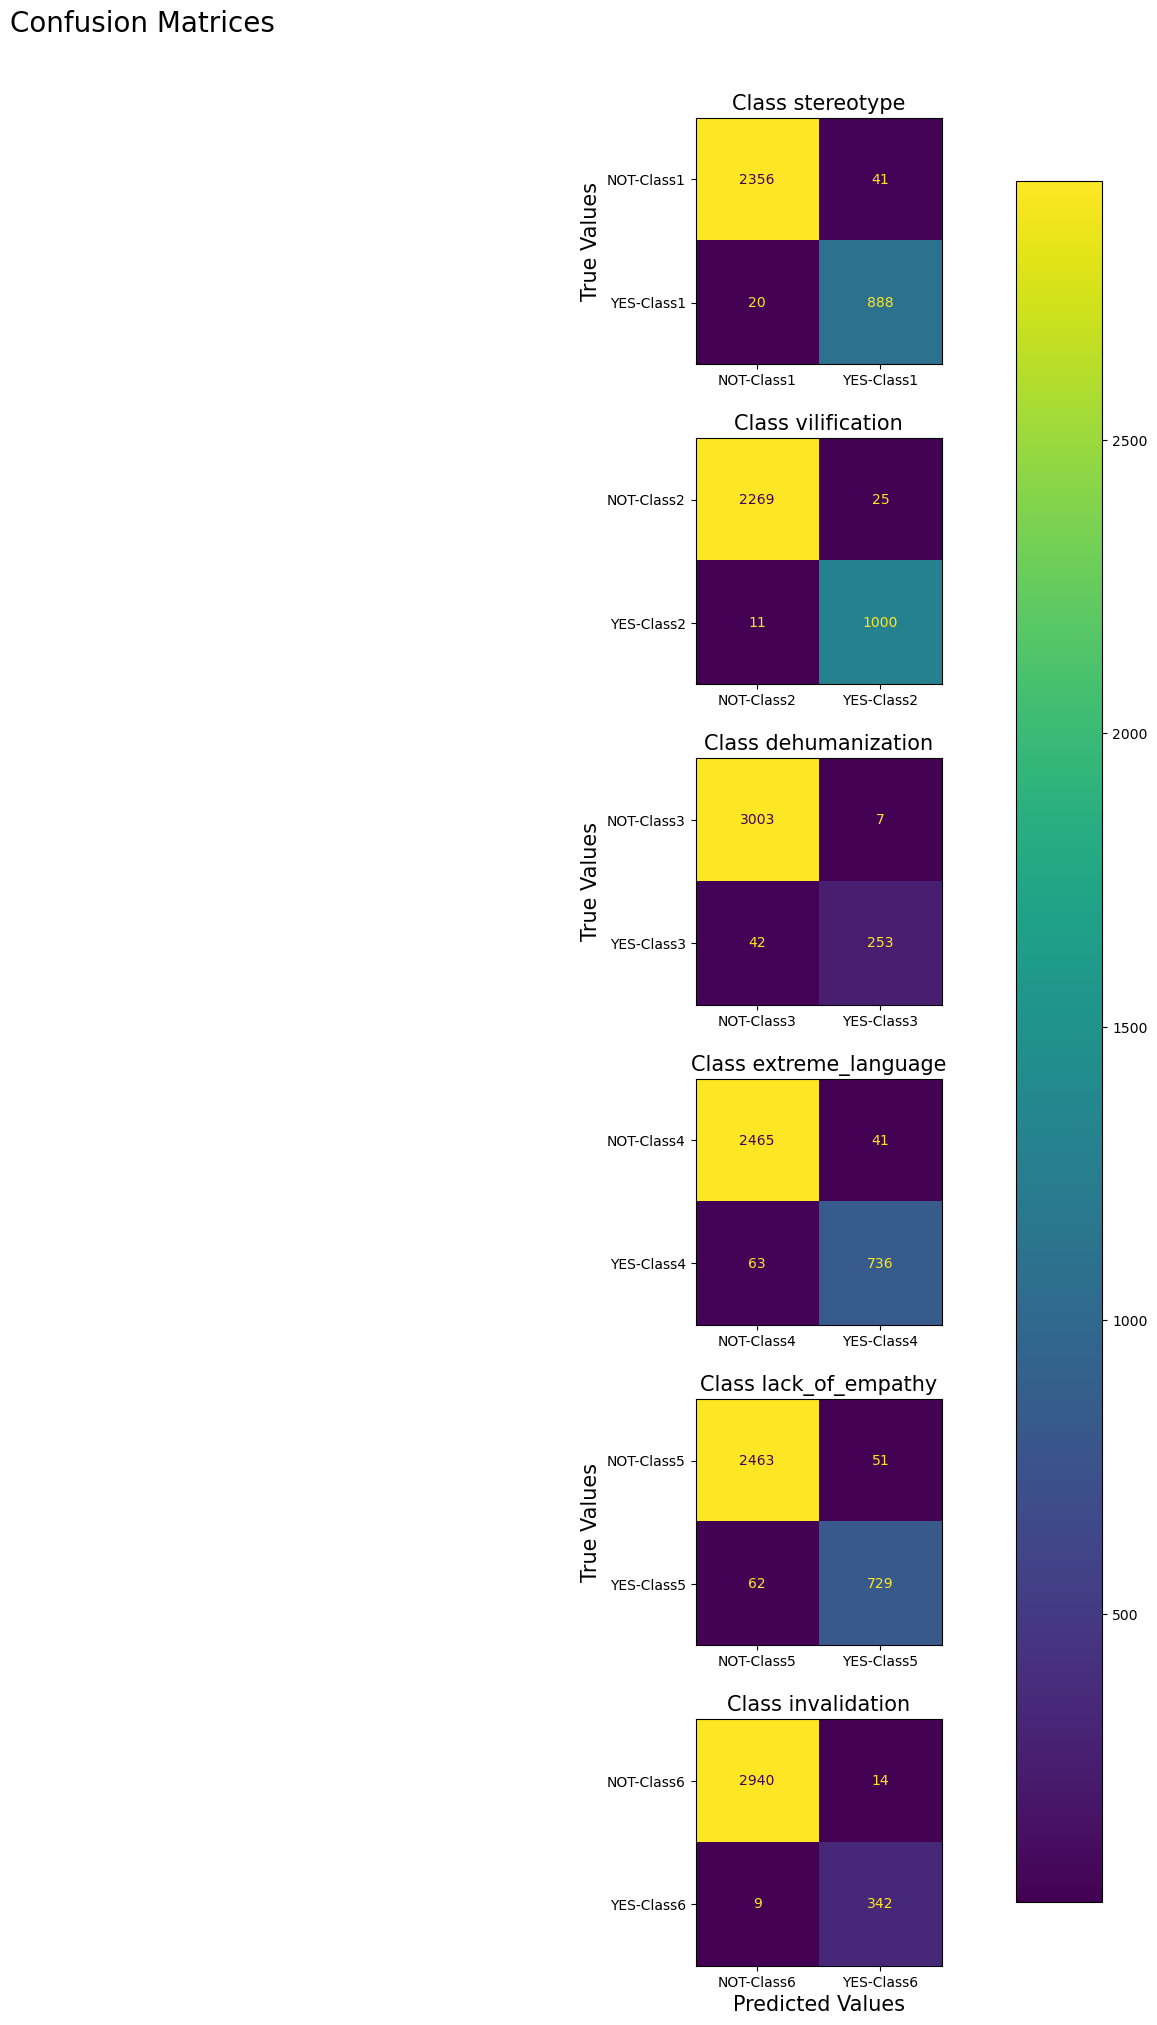

In [18]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6, 1, figsize=(24, 24))
axes = axes.ravel()
for i in range(len(labels)):
  y_true = [label[i] for label in test["labels"].tolist()]
  y_pred = [label[i] for label in test["predicted_labels"].tolist()]
  disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=[f"NOT-Class{i+1}", f"YES-Class{i+1}"])
  disp.plot(ax=axes[i], values_format='.4g')
  disp.ax_.set_title("Class {}".format(labels[i]), fontsize=15)  
  if i<5:
    disp.ax_.set_xlabel('')  
  else:
    disp.ax_.set_xlabel('Predicted Values', fontsize=15)  
  if i%2!=0:
    disp.ax_.set_ylabel('')  
  else:
    disp.ax_.set_ylabel('True Values', fontsize=15)
  disp.im_.colorbar.remove()
plt.subplots_adjust(wspace=0.25, hspace=0.3)
fig.colorbar(disp.im_, ax=axes, fraction=0.04625, pad=0.04)
plt.suptitle("Confusion Matrices", fontsize=20, y=0.925)
plt.show()

C:\Users\8888\AppData\Local\Temp\ipykernel_37668\4184596369.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
C:\Users\8888\AppData\Local\Temp\ipykernel_37668\4184596369.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve


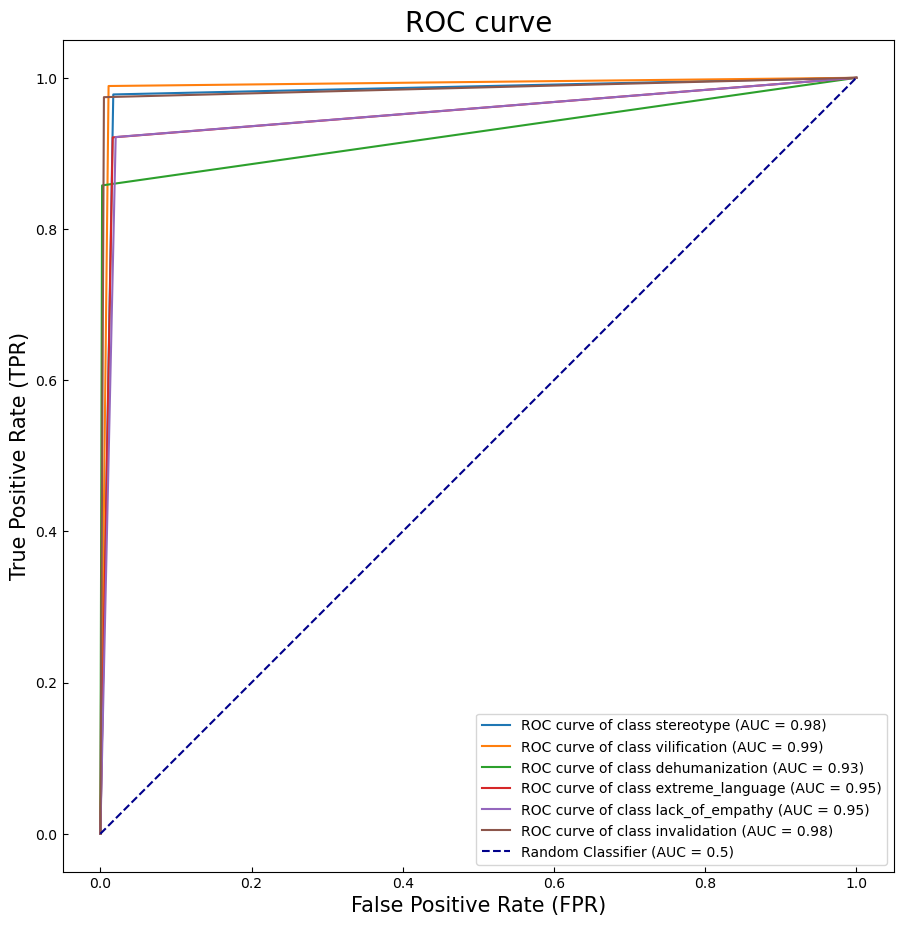

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
fig = plt.figure(figsize = (10.8, 10.8))
for i in range(len(labels)):
  y_true = [label[i] for label in test["labels"].tolist()]
  y_pred = [label[i] for label in test["predicted_labels"].tolist()]
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  plt.plot(fpr, tpr, label="ROC curve of class {} (AUC = {:0.2f})".format(labels[i], auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], "k--", color = "darkblue", linestyle = "--", label = "Random Classifier (AUC = 0.5)") # AUC: Area Under Curve
plt.axis("square")
plt.xlabel("False Positive Rate (FPR)", fontsize = 15)
plt.ylabel("True Positive Rate (TPR)", fontsize = 15)
plt.title("ROC curve", fontsize = 20)
plt.tick_params(axis = "y",direction = "in")
plt.tick_params(axis = "x",direction = "in")
plt.legend()
plt.show()